# Project description
This project tackles the problem of forecasting next‑year crop yields at the country level using historical FAO data. By training supervised regression models on country–crop–year records (e.g., tonnes per hectare of maize, wheat, rice, etc.), we aim to provide an accurate point forecast that agricultural planners and policymakers can use to anticipate production levels, optimize resource allocation, and inform food‑security strategies.

To achieve this, we will:

* Assemble & clean the FAO dataset (1961–2020) of country, crop, year, and yield values.

* Perform EDA to uncover trends, seasonality, and country‑specific patterns, and to quantify data quality (missingness, outliers, variability).

* Train & compare multiple regression models starting with a simple Linear Regression baseline and then xGBOOST

In [3]:
import numpy as np
import pandas as pd

# read dataframe 
df_yield = pd.read_csv("Data/yield.csv")
df_temp= pd.read_csv("Data/temp.csv")
df_rainfall = pd.read_csv("Data/rainfall.csv")
df_pesticides = pd.read_csv("Data/pesticides.csv")
df_yield_df = pd.read_csv("Data/yield_df.csv")

In [4]:
#chekcing info
df_yield.info()
df_temp.info()
df_rainfall.info()
df_pesticides.info()
df_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-nul

In [5]:
#rename and drop columns 
df_yield_df.drop(['Unnamed: 0'], axis = 1 ,inplace = True)
df_rainfall.rename(columns = {' Area':'Area'},inplace = True)
df_temp.rename(columns = {'year':'Year','country':'Area'},inplace = True) 

In [6]:
#merge data
df_temprain = pd.merge(df_rainfall,df_temp,on = ['Year','Area'])
df_trp = pd.merge(df_temprain,df_pesticides , on = ['Year','Area'])
yield_df = pd.merge(df_yield_df,df_yield, on = ['Year','Area','Item'])

# Exploratory data analysis

In [7]:
yield_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Domain Code,Domain,Area Code,Element Code,Element,Item Code,Year Code,Unit,Value
0,Albania,Maize,1990,36613,1485.0,121.0,16.37,QC,Crops,3,5419,Yield,56,1990,hg/ha,36613
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37,QC,Crops,3,5419,Yield,116,1990,hg/ha,66667
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37,QC,Crops,3,5419,Yield,27,1990,hg/ha,23333
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37,QC,Crops,3,5419,Yield,83,1990,hg/ha,12500
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37,QC,Crops,3,5419,Yield,236,1990,hg/ha,7000


In [8]:
print(yield_df['Item Code'].nunique())
print(yield_df['Item'].nunique())

10
10


In [9]:
print(yield_df['Domain'].nunique())
print(yield_df['Domain Code'].nunique())

1
1


In [10]:
print(yield_df['Area'].nunique())
print(yield_df['Area Code'].nunique())

101
101


In [11]:
print(yield_df['Element Code'].nunique())
print(yield_df['Element'].nunique())
print(yield_df['Unit'].nunique())

1
1
1


From the above it is evident that the Year Code and the Domain code are duplicate and irrelevent columns respectively. The Area code column is not useful for us for drawing any tangible conclusion. Domain also has only one value and hence dropping it. Dropping the columns. Area code is also representative of the Area code. hg/ha_yield And Value and Unit are all connected and hence dropping the last 2 columns .

In [12]:
## Making a copy of the dataset , because it may be required for later use

Yield_final_data = yield_df.copy()
Yield_final_data.drop(['Area Code','Year Code','Domain','Domain Code','Area Code','Item Code','Element','Element Code','Unit','Value'],axis = 1 , inplace = True)
Yield_final_data.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


The dataset must have the avg_temp in Celsius based on the temparature
There is data in the Item column where there are multiple crops listed by ' ,'.

In [13]:
Yield_final_data['Item'] = Yield_final_data['Item'].str.split(', ')
Yield_final_data = Yield_final_data.explode('Item').reset_index(drop=True)
Yield_final_data.shape
Yield_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31630 entries, 0 to 31629
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           31630 non-null  object 
 1   Item                           31630 non-null  object 
 2   Year                           31630 non-null  int64  
 3   hg/ha_yield                    31630 non-null  int64  
 4   average_rain_fall_mm_per_year  31630 non-null  float64
 5   pesticides_tonnes              31630 non-null  float64
 6   avg_temp                       31630 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


datset is in correct format

In [14]:
Yield_final_data.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,31630.000000,31630.000000,31630.000000,31630.000000,31630.000000
mean,2001.536895,73162.659437,1153.085267,37062.481868,20.620043
std,7.053614,81302.121833,712.805826,59771.245918,6.255367
min,1990.000000,50.000000,51.000000,0.040000,1.300000
25%,1995.000000,20918.000000,593.000000,1714.390000,16.780000
50%,2001.000000,37607.000000,1083.000000,17529.440000,21.550000
75%,2008.000000,94651.000000,1668.000000,48715.510000,26.030000
max,2013.000000,501412.000000,3240.000000,367778.000000,30.650000


In [15]:
Yield_final_data.groupby(['Area'],sort = True)[['hg/ha_yield']].sum().nlargest(10, 'hg/ha_yield')

,hg/ha_yield
Area,
India,342749968
Brazil,175935463
Mexico,139270288
Japan,133321962
Australia,121009524
Pakistan,80118288
Indonesia,75507330
Turkey,59531760
United Kingdom,55419990


In [16]:
Yield_final_data.groupby(['Area','Item'], sort=True)['hg/ha_yield'].sum().nlargest(10)

Area            Item          
India           Cassava           142810624
                Potatoes           92122514
Brazil          Potatoes           49602168
United Kingdom  Potatoes           46705145
Australia       Potatoes           45670386
India           Sweet potatoes     44439538
Japan           Potatoes           42918726
Mexico          Potatoes           42053880
                Sweet potatoes     35808592
Australia       Sweet potatoes     35550294
Name: hg/ha_yield, dtype: int64

In [17]:
Yield_final_data.groupby(['Item','Area'], sort=True)['hg/ha_yield'].sum().nlargest(10)

Item            Area          
Cassava         India             142810624
Potatoes        India              92122514
                Brazil             49602168
                United Kingdom     46705145
                Australia          45670386
Sweet potatoes  India              44439538
Potatoes        Japan              42918726
                Mexico             42053880
Sweet potatoes  Mexico             35808592
                Australia          35550294
Name: hg/ha_yield, dtype: int64

The datasets show that India is the highest datapoint in the Area column and 'Potato' is the dominant crop

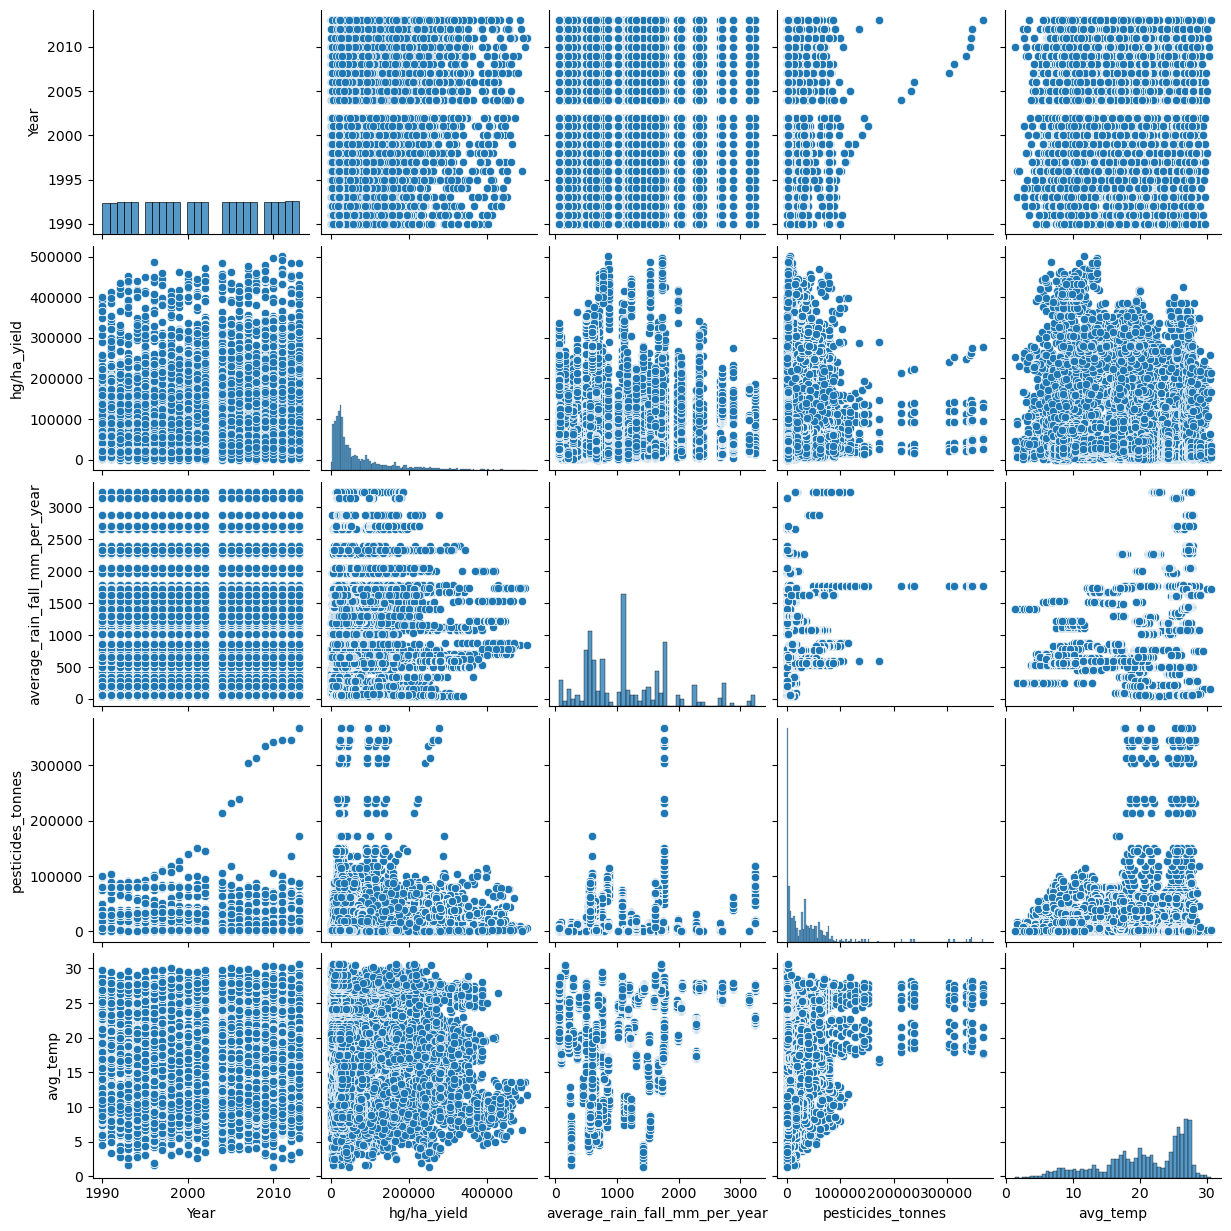

In [18]:
#explore pairplots
import seaborn as sns
sns.pairplot(Yield_final_data)

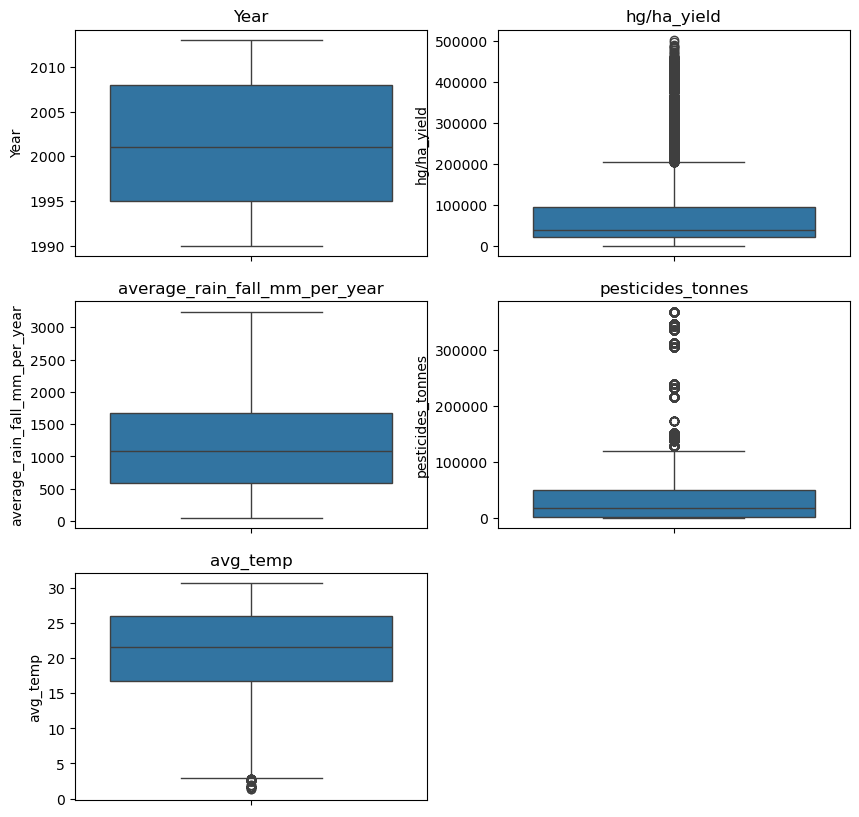

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,10))

plt.subplot(3,2,1)
sns.boxplot(data= Yield_final_data['Year'])
plt.title('Year')

plt.subplot(3,2,2)
sns.boxplot(data= Yield_final_data['hg/ha_yield'])
plt.title('hg/ha_yield')

plt.subplot(3,2,3)
sns.boxplot(data= Yield_final_data['average_rain_fall_mm_per_year'])
plt.title('average_rain_fall_mm_per_year')

plt.subplot(3,2,4)
sns.boxplot(data= Yield_final_data['pesticides_tonnes'])
plt.title('pesticides_tonnes')

plt.subplot(3,2,5)
sns.boxplot(data= Yield_final_data['avg_temp'])
plt.title('avg_temp')

plt.show()

We see that there are certain outliers in the avg_temp and pesticides_tonnes columns. 

In [20]:
Yield_final_data['Item'].value_counts()

Item
Potatoes                4276
Maize                   4121
Wheat                   3857
Rice                    3388
paddy                   3388
Soybeans                3223
Sorghum                 3039
Sweet potatoes          2890
Cassava                 2045
Yams                     847
Plantains and others     556
Name: count, dtype: int64

Paddy and Rice are the same crop and hence renaming them
Plantains and others may be any number of distinct crops in over 100 countries so dropping them because they may not anything valuable

In [21]:
Yield_final_data['Item'] = Yield_final_data['Item'].str.replace('paddy','Rice')
Yield_final_data = Yield_final_data[Yield_final_data['Item'] != 'Plantains and others']
Yield_final_data['Item'].value_counts()

Item
Rice              6776
Potatoes          4276
Maize             4121
Wheat             3857
Soybeans          3223
Sorghum           3039
Sweet potatoes    2890
Cassava           2045
Yams               847
Name: count, dtype: int64

Text(0.5, 1.0, 'Heatmap')

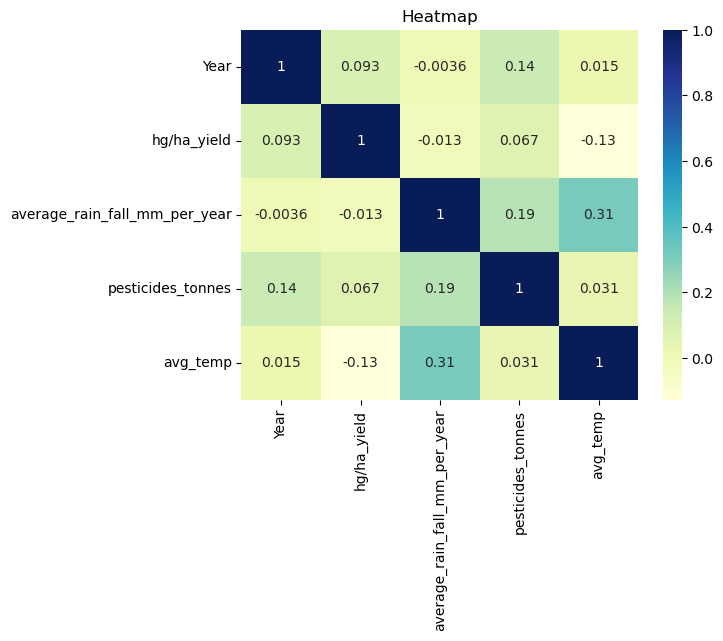

In [22]:
num_cor = Yield_final_data.select_dtypes(['int64','float64']).corr()
sns.heatmap(num_cor,cmap = 'YlGnBu',annot = True)
plt.title('Heatmap')

we cant really say their is a depp correlation between the different columns

<Axes: xlabel='Year', ylabel='Count'>

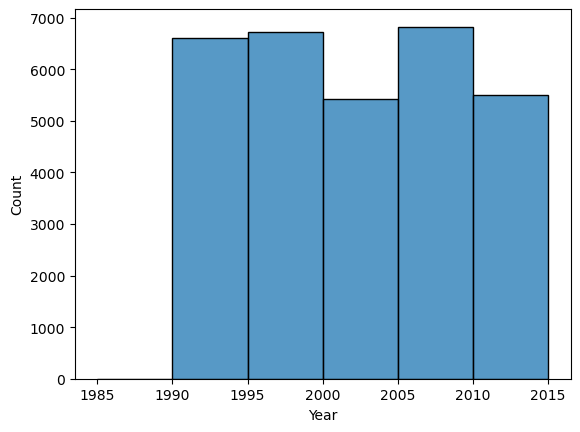

In [23]:
## Checking the data distribution in the 
sns.histplot(Yield_final_data, x = 'Year' , bins = range(1985, 2020, 5))

<Axes: xlabel='hg/ha_yield', ylabel='Count'>

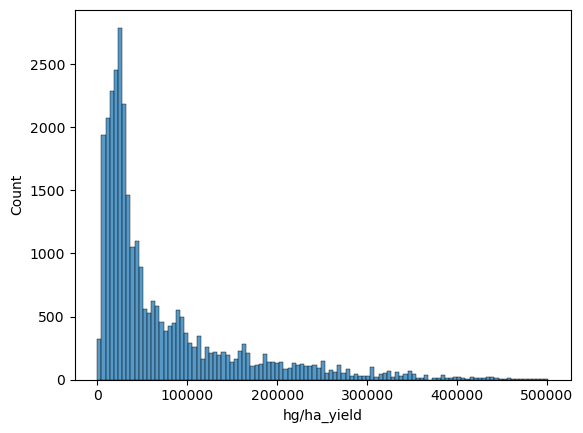

In [24]:
## Checking the data distribution in the yield column
sns.histplot(Yield_final_data, x = 'hg/ha_yield' )

<Axes: xlabel='pesticides_tonnes', ylabel='Count'>

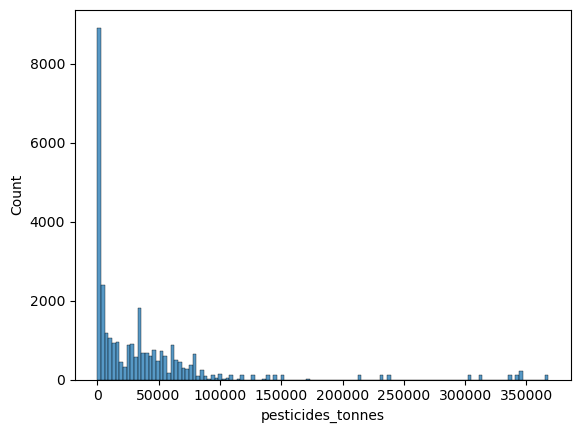

In [25]:
### Checking the pesticide usage data
## Checking the data distribution in the yield column
sns.histplot(Yield_final_data, x = 'pesticides_tonnes' )

There are outlier points in the datsets and hence dropping only the upper 5% data points to prevent high variance.

<Axes: xlabel='hg/ha_yield', ylabel='Count'>

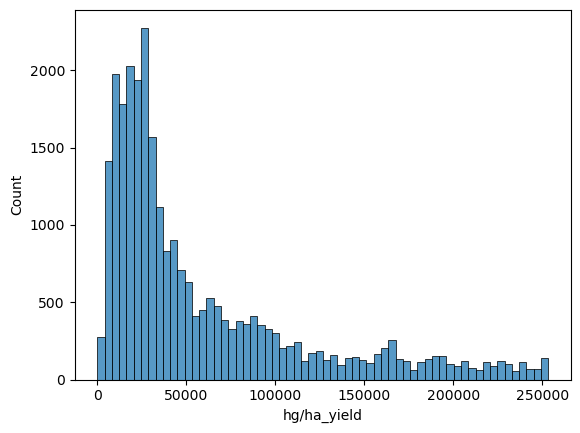

In [27]:
Yield_final_data = Yield_final_data[Yield_final_data['hg/ha_yield'] <= Yield_final_data['hg/ha_yield'].quantile(0.95)]
## Checking the data distribution in the yield column(if there have been any changes in the distribution after keeping only 90th quantile of yield)
sns.histplot(Yield_final_data, x = 'hg/ha_yield' )

<Axes: xlabel='pesticides_tonnes', ylabel='Count'>

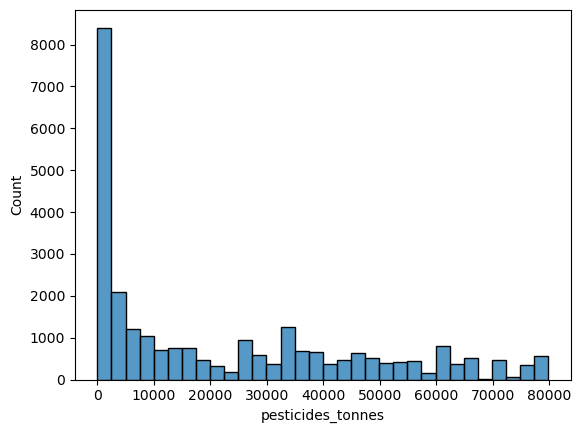

In [28]:
sns.histplot(Yield_final_data, x = 'pesticides_tonnes' )

Text(0.5, 1.0, 'Heatmap')

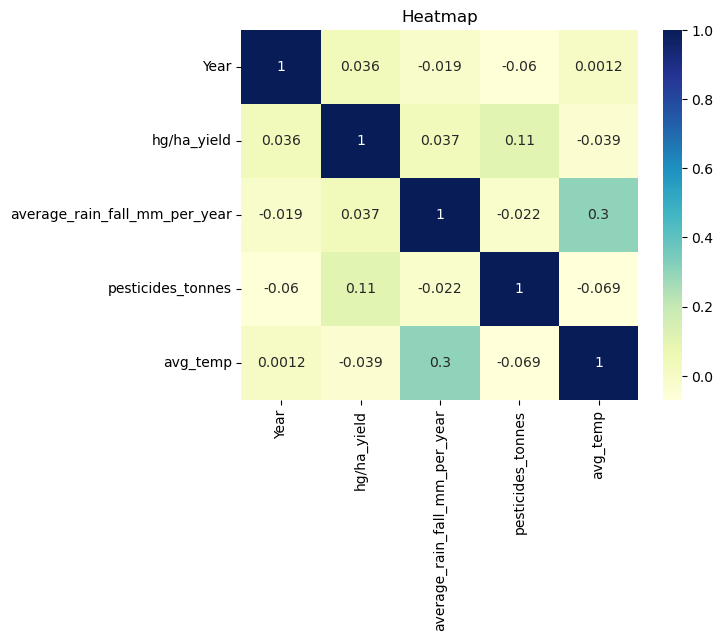

In [29]:
num_cor = Yield_final_data.select_dtypes(['int64','float64']).corr()
sns.heatmap(num_cor,cmap = 'YlGnBu',annot = True)
plt.title('Heatmap')

The features still do not bear high correlation and even though the pesticide and yield columns bear left skewness , we will not drop any rows any further fearing loss of information

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

Yield_final_data = pd.get_dummies(Yield_final_data,columns = ['Item','Area'], drop_first = True)
#Splitting the data in train ,test split
split_ratio = 0.25  
split_index = int(len(Yield_final_data) * split_ratio)

# Get the 'Year' value at the split point
split_year = Yield_final_data['Year'].iloc[split_index]

print(f"Split Year: {split_year}")

Split Year: 1997


In [31]:
df_train = Yield_final_data[Yield_final_data['Year'] <= 2009]
df_test  = Yield_final_data[Yield_final_data['Year'] > 2009]

df_train = df_train.drop('Year',axis = 1)
df_test  = df_test.drop('Year',axis = 1)

X_train = df_train.drop('hg/ha_yield',axis = 1 )
y_train = df_train['hg/ha_yield']
X_test  = df_test.drop('hg/ha_yield', axis = 1)
y_test  = df_test['hg/ha_yield']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22424, 111)
(22424,)
(4575, 111)
(4575,)


In [34]:
y_train.values.reshape(-1,1)
y_test.values.reshape(-1,1)

array([[ 66790],
       [231111],
       [ 16667],
       ...,
       [ 13142],
       [ 22222],
       [ 22888]], dtype=int64)

# Scaling and Model training

In [36]:
mmc = MinMaxScaler()
X_train = mmc.fit_transform(X_train)
X_test = mmc.transform(X_test)

### training the model with LR
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

Model_perf = pd.DataFrame(columns=['Model_Name','MSE','R2_Score'])

LR_mse = mean_squared_error(y_test,y_pred) 
LR_R2 = r2_score(y_test,y_pred)

new_row = {
    'Model_Name':   'Linear Regression',
    'MSE':          LR_mse,
    'R2_Score':     LR_R2
}

new_df = pd.DataFrame([new_row])
Model_perf = pd.concat([Model_perf, new_df], ignore_index=True)

C:\Users\user\AppData\Local\Temp\ipykernel_1132\477930766.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Model_perf = pd.concat([Model_perf, new_df], ignore_index=True)


In [41]:
# 2) XGBoost
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, n_estimators=300)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_xgb)
xgb_r2  = r2_score(y_test, y_xgb)

xgb_row = pd.DataFrame([{
    'Model_Name': 'XGB', 
    'MSE': xgb_mse, 
    'R2_Score': xgb_r2
}])
Model_perf = pd.concat([Model_perf, xgb_row], ignore_index=True)

# Model perfomance

In [42]:
print(Model_perf)

print("\nSorted by MSE:")
print(Model_perf.sort_values('MSE').reset_index(drop=True))

print("\nSorted by R2:")
print(Model_perf.sort_values('R2_Score', ascending=False).reset_index(drop=True))

          Model_Name           MSE      R2_Score
0  Linear Regression  7.521066e+28 -2.072762e+19
1                XGB  5.068424e+08  8.603172e-01

Sorted by MSE:
          Model_Name           MSE      R2_Score
0                XGB  5.068424e+08  8.603172e-01
1  Linear Regression  7.521066e+28 -2.072762e+19

Sorted by R2:
          Model_Name           MSE      R2_Score
0                XGB  5.068424e+08  8.603172e-01
1  Linear Regression  7.521066e+28 -2.072762e+19


# Conclusion & Insights

## XGBoost clearly outperforms Linear Regression

The XGB model achieved an MSE of ~5.07 × 10⁸ and an R² of 0.86, meaning it explains about 86 % of the variance in test yields.

In contrast, Linear Regression yielded an astronomically high MSE (7.5 × 10²⁸) and a massively negative R² (–2 × 10¹⁹), indicating it performs worse than simply predicting the mean.

## Why Linear Regression failed here

Crop‐yield relationships with factors like rainfall, soil pH, fertilizer application, and country effects are almost certainly nonlinear and may involve complex interactions (e.g. diminishing returns on fertilizer).

A plain linear model can’t capture those dynamics, leading to huge errors and an invalid fit.

## Why XGBoost succeeds

XGBoost’s tree‐based approach naturally handles nonlinearities, interactions, and mixed data types, which aligns well with the heterogeneous FAO dataset.

Its built‑in regularization and ensembling also guard against overfitting, giving a robust R² close to 0.9 on held‑out data.

## Next steps & recommendations

Feature Importance: Extract and plot XGBoost’s feature importances to identify which inputs (rainfall, soil pH, etc.) drive predictions.

Hyperparameter Tuning: Run a grid or randomized search (e.g. via scikit‑learn’s RandomizedSearchCV) over max_depth, learning_rate, and n_estimators to squeeze out even better performance.

Residual Analysis: Check residual plots for heteroscedasticity or patterns—this can guide further feature engineering (e.g. polynomial terms, log transforms).

Deployment: Serialize the trained XGBoost pipeline for your Streamlit app so users always get the best model’s predictions.

In [45]:
import joblib 
Yield_final_data.to_csv("crop_yield_cleaned.csv", index=False)
joblib.dump(xgb, "xgb_model.joblib")

['xgb_model.joblib']